In [474]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from pprint import pprint
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,LinearRegression,SGDRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import seaborn as sns

In [475]:
train_data=pd.read_csv("train.csv",index_col=0)

## Visualisation

Text(0, 0.5, 'Sale Price')

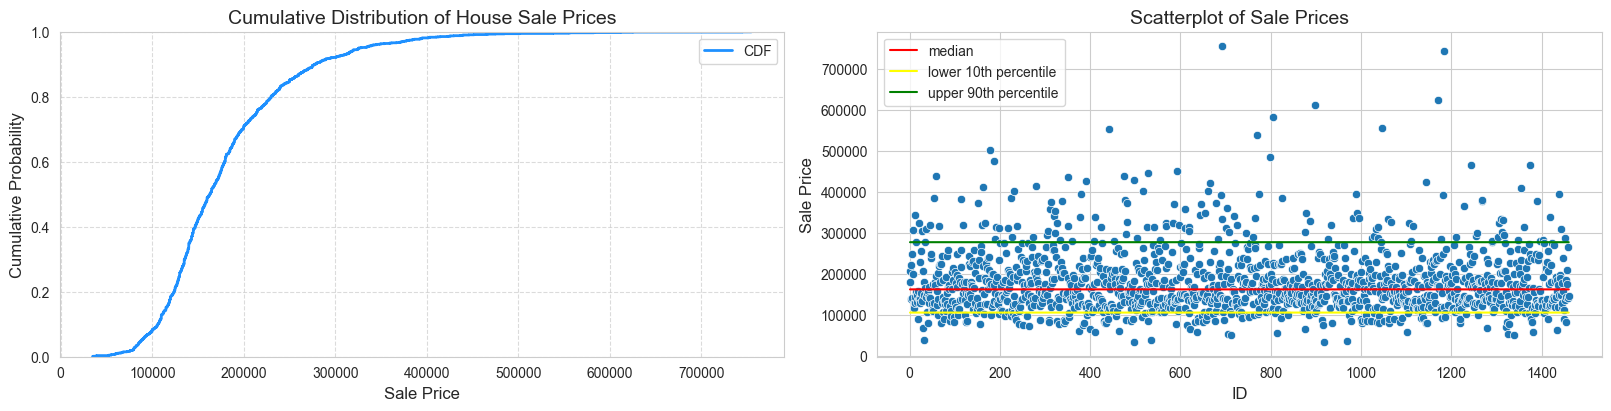

In [476]:
sns.set_style(style="whitegrid")
fig, ax = plt.subplots(figsize=(16, 4), layout="constrained",ncols=2)
sns.ecdfplot(data=train_data["SalePrice"], ax=ax[0], color="dodgerblue", label="CDF", linewidth=2)
ax[0].set_title("Cumulative Distribution of House Sale Prices", fontsize=14)
ax[0].set_xlabel("Sale Price", fontsize=12)
ax[0].set_ylabel("Cumulative Probability", fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].legend(loc="best", fontsize=10)

sns.scatterplot(train_data,x="Id",y="SalePrice",ax=ax[1])
sns.lineplot(train_data,x="Id",y=train_data["SalePrice"].median(),ax=ax[1],color="red",label="median")
sns.lineplot(train_data,x="Id",y=train_data["SalePrice"].quantile(0.1),ax=ax[1],color="yellow",label="lower 10th percentile")
sns.lineplot(train_data,x="Id",y=train_data["SalePrice"].quantile(0.9),ax=ax[1],color="green",label="upper 90th percentile")
ax[1].set_title("Scatterplot of Sale Prices", fontsize=14)
ax[1].set_xlabel("ID", fontsize=12)
ax[1].set_ylabel("Sale Price", fontsize=12)

## Data Preparation

In [477]:
num_col=list(train_data.select_dtypes(include=["int","float"]).columns)
cat_col=list(train_data.select_dtypes(include=["object"]).columns)
num_pipeline=Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
    #("std_scaler", StandardScaler())
])
pipeline=ColumnTransformer([
    ("num", num_pipeline,num_col),
    ("cat", OneHotEncoder(sparse_output=False,handle_unknown="infrequent_if_exist"),cat_col)
])
prepared_data = pipeline.fit_transform(train_data)
transformed_data = pd.DataFrame(prepared_data, columns=num_col + list(pipeline.named_transformers_["cat"].get_feature_names_out(cat_col)))
Y=transformed_data["SalePrice"]
X=transformed_data.copy()
X.drop("SalePrice",axis=1,inplace=True)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,train_size=0.8,random_state=10)

## Linear Regression

#### Model Training

In [478]:
%%time
lin_reg=LinearRegression()
lin_reg.fit(X,Y)

CPU times: total: 344 ms
Wall time: 32 ms


LinearRegression()

#### Evaluation

In [479]:
predict=pd.DataFrame(lin_reg.predict(X_test))
rmse=root_mean_squared_error(Y_test,predict)
mse=mean_squared_error(Y_test,predict)
mae=mean_absolute_error(Y_test,predict)
l=[]
l.append(Y_train.mean())
l=l*292
mean_guess=pd.DataFrame(l)
print("RMSE: ",rmse)
print("MSE: ",mse)
print("MAE: ",mae)
print("Mean Guess MAE: ",mean_absolute_error(Y_test,mean_guess))
cv_scores = cross_val_score(lin_reg, X_train, Y_train, scoring='r2', cv=5)
print("Cross-Validated R-squared scores:", cv_scores)
print("Mean R-squared:", cv_scores.mean())

RMSE:  20348.315294640077
MSE:  414053935.3300833
MAE:  13839.568884501678
Mean Guess MAE:  59669.224015997366
Cross-Validated R-squared scores: [ 8.47343503e-01  8.61800845e-01  1.66049920e-01 -6.46703904e+07
  7.50247971e-01]
Mean R-squared: -12934077.564041529


#### Output

In [480]:
test_data=pd.read_csv("test.csv",index_col=0)
test_data["SalePrice"]=0
test_data=pipeline.transform(test_data)
test_data = pd.DataFrame(test_data, columns=num_col + list(pipeline.named_transformers_["cat"].get_feature_names_out(cat_col)))
test_data.drop("SalePrice",axis=1,inplace=True)
test_data_predict=lin_reg.predict(test_data)
test_data_predict=pd.DataFrame(test_data_predict)
result=pd.read_csv("test.csv")
test_data_predict["Id"]=result["Id"]
test_data_predict.set_index("Id",inplace=True)
test_data_predict.to_csv("linear_regression.csv")

## Random Forest

#### Model Training

In [481]:
%%time
rf=RandomForestRegressor()
cv_params={
    "n_estimators":[300,350,400,500],"max_depth":[6,8,10,16],"max_features" : ["sqrt", "log2",1.0], 'min_samples_split': [2,4,6,None],'min_samples_leaf': [5,6,7,8,9,10,None],"criterion" :['squared_error',"gini","log_loss"]
}
randomforest_cv=GridSearchCV(rf,cv_params,n_jobs=4)
randomforest_cv.fit(X,Y)

C:\Users\Kay\PycharmProjects\practice\venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15840 fits failed out of a total of 20160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1440 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kay\PycharmProjects\practice\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kay\PycharmProjects\practice\venv\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\Kay\PycharmProjects\practice\venv\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    val

CPU times: total: 13.1 s
Wall time: 26min 16s


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'criterion': ['squared_error', 'gini', 'log_loss'],
                         'max_depth': [6, 8, 10, 16],
                         'max_features': ['sqrt', 'log2', 1.0],
                         'min_samples_leaf': [5, 6, 7, 8, 9, 10, None],
                         'min_samples_split': [2, 4, 6, None],
                         'n_estimators': [300, 350, 400, 500]})

#### Evaluation

In [482]:
predict=pd.DataFrame(randomforest_cv.predict(X_test))
rmse=root_mean_squared_error(Y_test,predict)
mse=mean_squared_error(Y_test,predict)
mae=mean_absolute_error(Y_test,predict)
l=[]
l.append(Y_train.mean())
l=l*292
mean_guess=pd.DataFrame(l)
print("RMSE: ",rmse)
print("MSE: ",mse)
print("MAE: ",mae)
print("Mean Guess MAE: ",mean_absolute_error(Y_test,mean_guess))
cv_scores = cross_val_score(lin_reg, X_train, Y_train, scoring='r2', cv=5)
print("Cross-Validated R-squared scores:", cv_scores)
print("Mean R-squared:", cv_scores.mean())

RMSE:  18510.436566433287
MSE:  342636261.8799505
MAE:  11745.680090518901
Mean Guess MAE:  59669.224015997366
Cross-Validated R-squared scores: [ 8.47343503e-01  8.61800845e-01  1.66049920e-01 -6.46703904e+07
  7.50247971e-01]
Mean R-squared: -12934077.564041529


#### Output

In [484]:
test_data=pd.read_csv("test.csv",index_col=0)
test_data["SalePrice"]=0
test_data=pipeline.transform(test_data)
test_data = pd.DataFrame(test_data, columns=num_col + list(pipeline.named_transformers_["cat"].get_feature_names_out(cat_col)))
test_data.drop("SalePrice",axis=1,inplace=True)
test_data_predict=randomforest_cv.predict(test_data)
test_data_predict=pd.DataFrame(test_data_predict)
result=pd.read_csv("test.csv")
test_data_predict["Id"]=result["Id"]
test_data_predict.set_index("Id",inplace=True)
test_data_predict.to_csv("random_forrest.csv")